# Preview a bunch of trajectories from individual experiments as a table of plots

#### Written by Matan Yah Ben Zion 20230305

In [6]:
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def l2n(x):
    return np.array(x)

In [172]:
expSumFileName = 'transportExpSum20230306bots21_.csv'
expSum = pd.read_csv(expSumFileName,index_col=0)

In [173]:
def timeToSec(timeStr):
    timeArr = timeStr.split(':')
    timeMin = int(timeArr[0])
    timeSec = int(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 

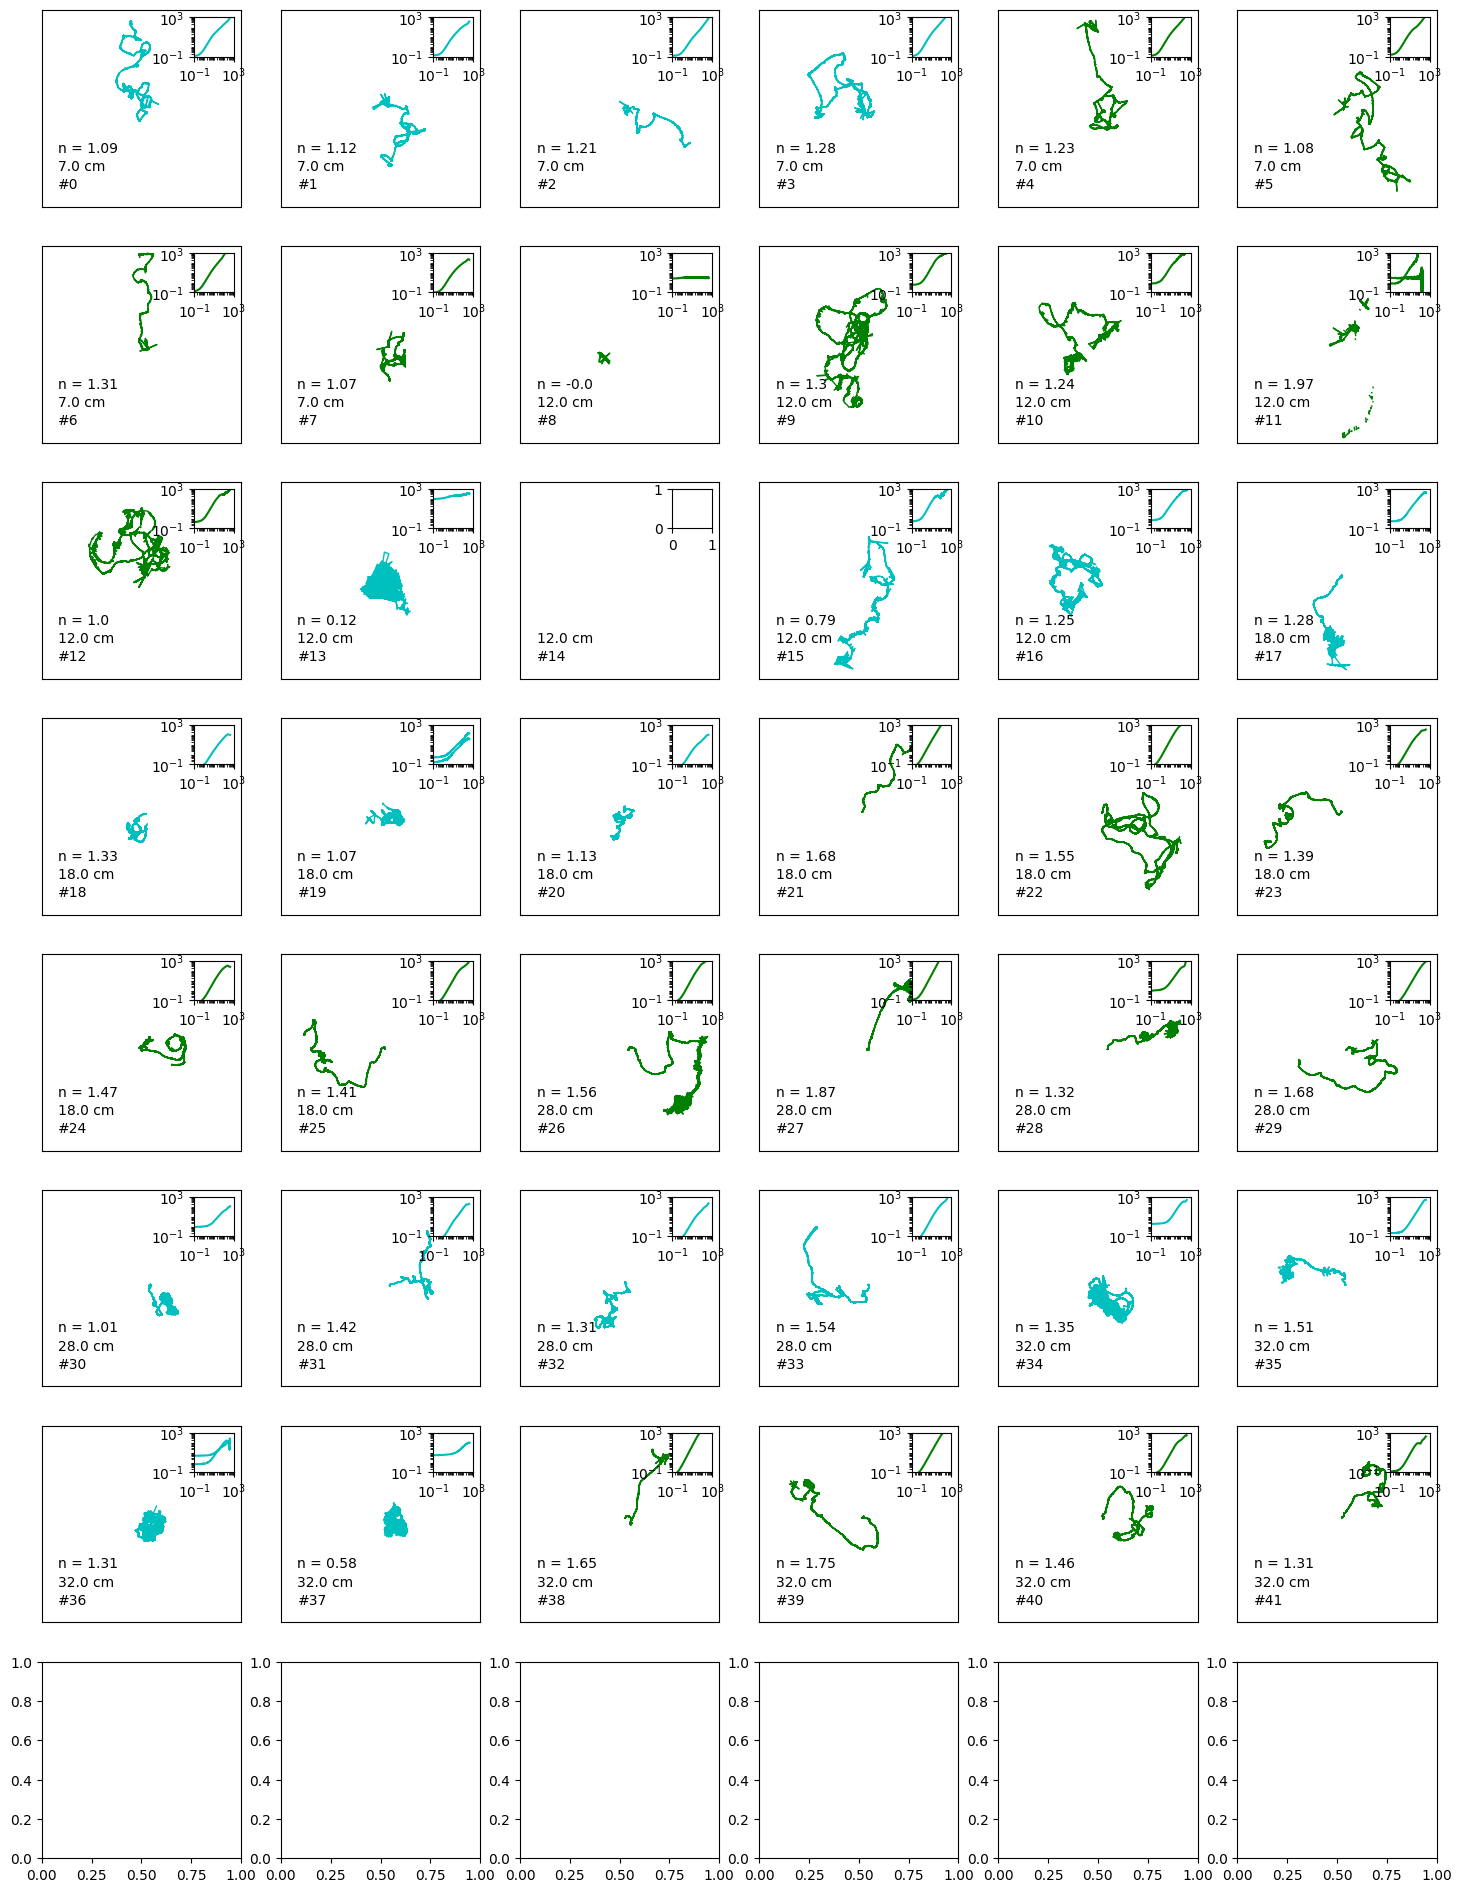

In [177]:
alignerColor = 'c'
fronterColor = 'g'
nrows = 7
ncols = 6
fig3,axs3 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(18,21))
df=[]
dfPowerSummary = pd.DataFrame({'path':[],'linkingFileName':[],'bots':[],'botType':[],'passiveDiameter[cm]':[],'power':[],'Coeef':[]})
                            
for index,row in expSum.iterrows():
    botType = row.bottype
    passDiam = row['passiveDiameter[cm]']
    Nbots = row['bots']
    fileNameLinked = row['linkingFileName']
    fileNameVideo = row.path
    pixelSize = row['pixelSize [cm/pixel]']
    fps = row['fps']
    
    df = pd.read_csv(fileNameLinked)#,index_col=0)
    nParticles = len(df.particle.unique())
    i = int(index/ncols)
    j = index%ncols
    ax = axs3[i,j]
    axins = inset_axes(ax, width="20%", height="20%")
    if(nParticles>0):
        if botType =='aligner':
            color = alignerColor
        elif botType =='fronter':
            color = fronterColor
        tp.plot_traj(df,ax=ax,plot_style={'color':color})
        
        #Time between experiment start and before touching the wall or video ened (or 20mins elapsed)
        startSec = timeToSec(row.start_min)
        endSec = timeToSec(row.end_min)
        startFrame = startSec*fps
        endFrame = endSec*fps
        
        cond = (startFrame < df.frame) & (df.frame<endFrame)
        dfC = df[cond]
        imsd = tp.imsd(dfC,pixelSize, fps=fps,max_lagtime=10000)
        axins.loglog(imsd,color=color)
        axins.axis([1E-1,1E3,1E-1,1E3])
        axins.set_xticks([1E-1,1E3])
        axins.set_yticks([1E-1,1E3])
        cond = (1<imsd.index)&(imsd.index<100)
        powerLawFit = tp.utils.fit_powerlaw(imsd[cond],plot=False)
        power = powerLawFit.n.values[0]
        coeff = powerLawFit.A.values[0]
        
        dfPower = pd.DataFrame({'path':[fileNameVideo],'linkingFileName':[fileNameLinked],'bots':[Nbots],'botType':[botType],'passiveDiameter[cm]':[passDiam],'power':[power],'Coeef':[coeff]})
        dfPowerSummary = pd.concat([dfPowerSummary,dfPower],ignore_index=True)
        
        ax.text(100,300,'n = '+str(np.round(power,2)))
                         
    ax.axis([0,1200,0,1080])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(100,100,'#'+str(index))
    ax.text(100,200,str(passDiam)+' cm')
    print(str(index)+', ', end="")
fig3.savefig('allTrajectoriesAndMSDs20230306_.png',bbox_inches='tight')

In [210]:
diams = dfPowerSummary['passiveDiameter[cm]'].unique()
botTypes = dfPowerSummary['botType'].unique()
nAm = []
nFm = []
nAerr =[] 
nFerr = []
dfPowerMeans = pd.DataFrame({'botType':[],'passiveDiameter[cm]':[],'power':[],'powerErr':[]})


for diam in diams:
    dfPowerSummaryDiam = dfPowerSummary[dfPowerSummary['passiveDiameter[cm]']==diam]
    #temporaarly remove haux fits (ie. #13)
    #dfPowerSummaryDiam = dfPowerSummaryDiam[dfPowerSummaryDiam.power>0.5]
    for botType in botTypes:
        dfPowerSummaryDiamBotType = dfPowerSummaryDiam[dfPowerSummaryDiam.botType==botType]

        nMean = dfPowerSummaryDiamBotType.power.mean()
        nErr = dfPowerSummaryDiamBotType.power.std()/len(dfPowerSummaryDiamBotType)**0.5
        dfPowerMean = pd.DataFrame({'botType':[botType],'passiveDiamater[cm]':[diam],'power':[nMean],'powerErr':[nErr]})
        dfPowerMeans = pd.concat([dfPowerMeans,dfPowerMean],ignore_index=True)
        

In [211]:
#Means for Fronters
dfPowerMeansF = dfPowerMeans[dfPowerMeans.botType=='fronter']

#Means for Aligners
dfPowerMeansA = dfPowerMeans[dfPowerMeans.botType=='aligner']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


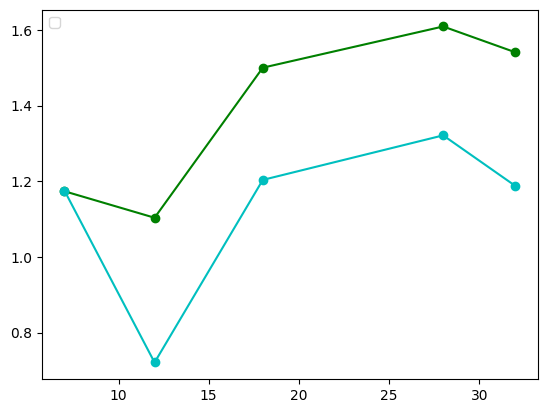

In [216]:
fig,ax =plt.subplots()


x,y,yErr = dfPowerMeansF['passiveDiamater[cm]'].values,dfPowerMeansF['power'].values,dfPowerMeansF['powerErr'].values
#ax.errorbar(x,y,yErr,label='fronter',color=fronterColor)
ax.plot(x,y,'o-',color=fronterColor)
x,y,yErr = dfPowerMeansA['passiveDiamater[cm]'].values,dfPowerMeansA['power'].values,dfPowerMeansA['powerErr'].values
#ax.errorbar(x,y,yErr,label='aligner',color=alignerColor)
ax.plot(x,y,'o-',color=alignerColor)
ax.legend(loc='upper left')

In [220]:
deltaT = df.frame.diff(10)[10:]
deltaX = 

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
23153    10.0
23154    10.0
23155    10.0
23156    10.0
23157    10.0
Name: frame, Length: 23158, dtype: float64

In [151]:
expSum.stars

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     2.0
7     3.0
8     2.0
9     1.0
10    3.0
11    1.0
12    3.0
13    NaN
14    NaN
15    1.0
16    1.0
17    1.0
18    1.0
19    2.0
20    2.0
21    2.0
22    1.0
23    2.0
24    1.0
25    3.0
26    1.0
27    1.0
28    2.0
29    1.0
30    1.0
31    NaN
32    NaN
33    3.0
34    NaN
35    NaN
36    NaN
37    NaN
38    NaN
39    3.0
40    1.0
41    1.0
42    1.0
Name: stars, dtype: float64

In [144]:
print(expSum[expSum['end_min'].isnull()]['path'])

16      D:\Eden\22_12_22_blend\alingners-12cm\C0529.MP4
17    D:\Eden\22_12_22_blend\alingners-12cm\no_black...
18       D:\Eden\22_12_22_blend\alingers-18cm\C0527.MP4
19       D:\Eden\22_12_22_blend\alingers-18cm\C0526.MP4
20       D:\Eden\22_12_22_blend\alingers-18cm\C0525.MP4
21       D:\Eden\22_12_22_blend\alingers-18cm\C0523.MP4
22       D:\Eden\22_12_22_blend\fronters-18cm\C0521.MP4
23       D:\Eden\22_12_22_blend\fronters-18cm\C0519.MP4
24     D:\Eden\20221220\fronters21passive18cm\C0514.MP4
25     D:\Eden\20221220\fronters21passive18cm\C0516.MP4
26     D:\Eden\20221220\fronters21passive18cm\C0517.MP4
27                D:\Eden\20221213\fronters21\C0490.MP4
28                D:\Eden\20221213\fronters21\C0491.MP4
29                D:\Eden\20221213\fronters21\C0492.MP4
30                D:\Eden\20221213\fronters21\C0493.MP4
31                D:\Eden\20221213\aligners21\C0494.MP4
32                D:\Eden\20221213\aligners21\C0495.MP4
33                D:\Eden\20221213\aligners21\C0

In [98]:
df = pd.read_csv(row['linkingFileName'])#,index_col=0)

In [112]:
cond = (df.particle==0)&(df.frame<5000)

imsd = tp.imsd(df[cond],pixelSize, fps=fps,max_lagtime=10000)

In [113]:
cond = (1<imsd.index)&(imsd.index<100)
imsd[cond]

,0
lag time [s],
1.04,1.176495
1.08,1.262112
1.12,1.298678
1.16,1.255364
1.20,1.304633
...,...
99.80,2973.706482
99.84,2944.453503
99.88,2897.670187


In [114]:
powerLawFit = tp.utils.fit_powerlaw(imsd[cond],plot=False)
power = powerLawFit.n.values[0]

In [115]:
power

1.878348453055239

(0.0, 1200.0, 0.0, 1080.0)

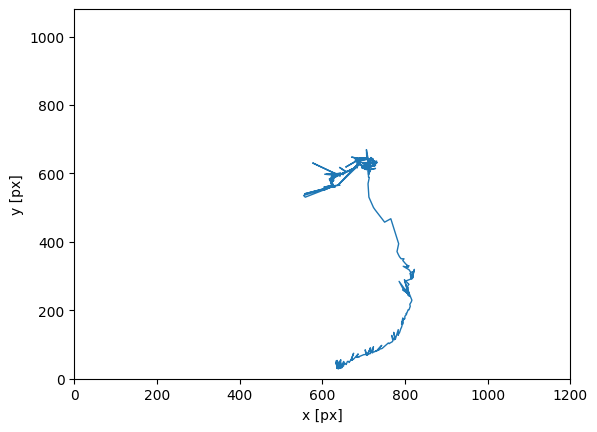

In [117]:
fig,ax=plt.subplots()
tp.plot_traj(df[df.particle==0],ax=ax)
ax.axis([0,1200,0,1080])

In [83]:
1400/25

56.0

In [82]:
len(df[df.particle==3])

1410

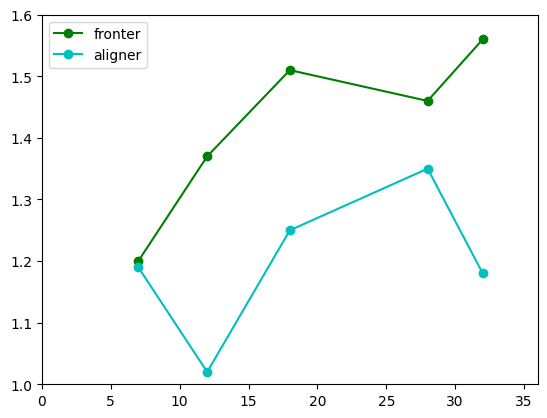

In [65]:
powFr = l2n([1.2,1.37,1.51,1.46,1.56])
powAl = l2n([1.19,1.02,1.25,1.35,1.18])
ds = l2n([7,12,18,28,32])

fig,ax =plt.subplots()

ax.plot(ds,powFr,color = fronterColor,label='fronter',marker='o')
ax.plot(ds,powAl,color = alignerColor,label='aligner',marker='o')
ax.legend()
ax.axis([0,36,1,1.6])
fig.savefig('meanPowerLaw21bots_.png',bbox_inches='tight')

In [52]:
zzz = imsd.copy()
cond = (1<imsd.index)&(imsd.index<100)
power = tp.utils.fit_powerlaw(imsd[cond],plot=False)
power.n.values[0]

1.3956596067890956

In [66]:
pwd

'C:\\Users\\User\\Documents\\Eden\\locate_git_code'